In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [3]:
# simple data preprocessing to help with training
st_dev = np.std(x_train)
mean = np.mean(x_train)
x_train = (x_train - mean) / st_dev
x_test = (x_test - mean) / st_dev

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Flatten, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam

In [5]:
def get_new_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(20),
        BatchNormalization(),
        Activation('relu'),
        Dense(10),
        BatchNormalization(),
        Activation('softmax')
    ])
    model.compile(Adam(lr=1e-2), 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
get_new_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                15700     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
batch_normalization_2 (Batch (None, 10)                40        
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total para

In [7]:
# Deltas for step sizes in weight space - roughly 1 std dev for each set of weights based on a single data point
dense1_delta = 0.25
dense1_bias_delta = 0.004
dense4_delta = 0.4
dense4_bias_delta = 0.05

In [8]:
train_results, test_results = [], []
train_results_with_deltas = []

step_size = 0.2
models_to_evaluate = 100
measurements_per_model = 20

for i in range(models_to_evaluate):
    model = get_new_model()
    h = model.fit(x_train, y_train, batch_size=256, shuffle=True, epochs=4,
                  validation_data=(x_test, y_test), verbose=0)

    train_results.append(model.evaluate(x_train, y_train, batch_size=60000, verbose=0))
    test_results.append(model.evaluate(x_test, y_test, batch_size=10000, verbose=0))
    
    # Storing weights so that we can alter them multiple times
    dense1 = model.layers[1].get_weights()[0]
    dense1_bias = model.layers[1].get_weights()[1]
    dense4 = model.layers[4].get_weights()[0]
    dense4_bias = model.layers[4].get_weights()[1]

    results_with_deltas = []
    
    for _ in range(measurements_per_model):
        # Applying random deltas to the weights
        model.layers[1].set_weights([
            dense1 + np.random.normal(size=(784, 20)) * dense1_delta * step_size,
            dense1_bias + np.random.normal(size=(20,)) * dense1_bias_delta * step_size
        ])
        model.layers[4].set_weights([
            dense4 + np.random.normal(size=(20, 10)) * dense4_delta * step_size,
            dense4_bias + np.random.normal(size=(10,)) * dense4_bias_delta * step_size
        ])

        # Evaluating the model on the train set again and storing results
        results_with_deltas.append(model.evaluate(x_train, y_train, batch_size=60000, verbose=0))
        
    train_results_with_deltas.append(results_with_deltas)

In [9]:
train_loss = np.array([measurement[0] for measurement in train_results])
test_loss = np.array([measurement[0] for measurement in test_results])
train_loss_with_deltas = np.array([[m[0] for m in measurements] for measurements in train_results_with_deltas])
print(f'Average accuracy: {np.mean(np.array([measurement[1] for measurement in test_results]))}')

Average accuracy: 0.9535101228952407


In [10]:
generalization_deltas = test_loss - train_loss
perturbation_deltas = train_loss_with_deltas - train_loss.reshape(models_to_evaluate, -1)
perturbation_deltas_sum = np.sum(np.abs(perturbation_deltas), axis=1)

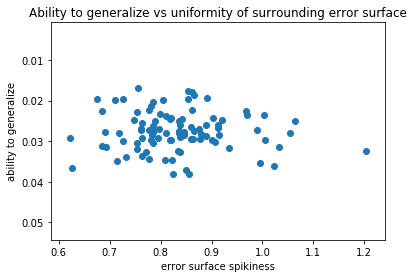

In [11]:
plt.scatter(perturbation_deltas_sum, generalization_deltas)
plt.gca().invert_yaxis()
plt.xlabel('error surface spikiness')
plt.ylabel('ability to generalize')
plt.title('Ability to generalize vs uniformity of surrounding error surface')